In [1]:
cd /content/drive/My Drive/TPML/Project

/content/drive/My Drive/TPML/Project


In [ ]:
ls 

 1905.05583.pdf                    meta_All_Beauty.json
 best_model_state_400_10.bin       meta_Appliances.json
 best_model_state_400.bin          meta_Luxury_Beauty.json
 best_model_state_512_lr5e-6.bin   meta_Musical_Instruments.json
 best_model_state.bin              Musical_Instruments_5.json
 data_understanding.ipynb          Musical_Instruments.csv
 GoodReads_Book_02-09-2020.csv     processed_reviews.csv
 GoodReads_Review_02-09-2020.csv   result/
 history400_10.csv                 sentiment_analysis.ipynb
 history400.csv                   'test (1).gsheet'
 history400.gsheet                 test.csv
 history400.json                   test.gsheet
 history512_lr5e-6.csv


In [ ]:
pip install textblob

In [2]:
import pandas as pd
import re
import numpy as np

# Preprocess

In [ ]:
rev = pd.read_csv('GoodReads_Review_02-09-2020.csv',dtype = str)

In [ ]:
rev.shape

(32611, 6)

In [ ]:
rev.head()

,BookID,BookTitle,ReviewerName,ReviewerComment,ReviewerRating,ReviewDate
0,27276412,When We Meet Again by Kristin Harmel,Jennifer ~ TarHeelReader,"My first book by Kristin Harmel was charming, ...",4,15-Apr-17
1,27276412,When We Meet Again by Kristin Harmel,Melissa,After reading some of Kristin Harmel's previou...,5,22-May-16
2,27276412,When We Meet Again by Kristin Harmel,Kelli,I really don't know where to begin and I am no...,4,8-May-16
3,27276412,When We Meet Again by Kristin Harmel,Jan Rice,"This book hooked me, and I read it all the way...",3,24-Jun-19
4,27276412,When We Meet Again by Kristin Harmel,Rachael Burrows,I am an official reviewer for NetGalley. With ...,5,15-Mar-16


In [ ]:
rev.ReviewerRating.value_counts()

5    13315
4    10984
3     4797
2     2302
1     1213
Name: ReviewerRating, dtype: int64

In [ ]:
rev.loc[rev.ReviewerRating=='2','ReviewerComment']

7        I was very interested in the premise of this b...
16       The story is not very convincing and rather pr...
20       2.5 StarsVery mixed feelings about this one. I...
39       There’s an important story here (at least in t...
43       I found The Great Believers really dry and bor...
                               ...                        
32571    This book is very difficult to rate. There wer...
32577    I first learned about Alex Honnold, the guy wh...
32579    While certainly an interesting account of clim...
32581    So this is a book about a young man who climbs...
32607    Yet another disappointing historical read (tha...
Name: ReviewerComment, Length: 2302, dtype: object

Some thoughts:
1. 0-3 neg; 4-5 pos for a relatively balanced data
2. 0-2 neg; 3 neutral, 4-5 pos; ref: https://medium.com/life-at-hopper/conducting-sentiment-analysis-on-app-reviews-to-inform-product-decisions-64fcc71822ed#:~:text=If%20we%20assume%20that%20the,overall%20sentiment%20%E2%80%94%20the%20star%20rating.

  Maybe try a rough eval with nltk;

  when doing recommendation, how to handle neutral?

3. drop 3; only train on extreme opinions

Other refs:
https://bookriot.com/truth-three-star-review-not-bad-review/

https://medium.com/southpigalle/how-to-perform-better-sentiment-analysis-with-bert-ba127081eda

In [ ]:
sub_rev = rev.loc[:,['ReviewerComment','ReviewerRating']]

In [ ]:
sub_rev.ReviewerComment[1]

'After reading some of Kristin Harmel\'s previous novels and loving them, I knew I had to get my hands on this one too. Kristin has proven herself once again to be a skilled storyteller. When We Meet Again reminded me of The Sweetness of Forgetting, but there are some differences, as well. Both are about women who are in a rut in their own lives, searching for answers about their grandparents\' lives. The historical aspects of both stories was around World War II. While "Sweetness" started in France, this story started in Germany. Also, both women looked like their grandmothers. In When We Meet Again, we get the male perspective from the past, which I thought was interesting.If I had more time, I would have devoured this book in one sitting. The mystery of who Emily\'s grandfather really was, and how she would even be able to find him, carried the story from beginning to end. We got glimpses of what life was like for her grandfather, as well. (Let\'s just say, the circumstances were he

In [ ]:
sub_rev['comment_nourl'] = sub_rev.ReviewerComment.apply(lambda x : re.sub(r'^https?:\/\/.*[\r\n]*', '',x))

In [ ]:
sub_rev.head()

,ReviewerComment,ReviewerRating,comment_nourl
0,"My first book by Kristin Harmel was charming, ...",4,"My first book by Kristin Harmel was charming, ..."
1,After reading some of Kristin Harmel's previou...,5,After reading some of Kristin Harmel's previou...
2,I really don't know where to begin and I am no...,4,I really don't know where to begin and I am no...
3,"This book hooked me, and I read it all the way...",3,"This book hooked me, and I read it all the way..."
4,I am an official reviewer for NetGalley. With ...,5,I am an official reviewer for NetGalley. With ...


In [ ]:
pip install langdetect

     |████████████████████████████████| 983kB 12.1MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.8-cp36-none-any.whl size=993195 sha256=0ae355c42e55e6dba892cdb15a2466980e9706518cee563eb6a75efa61f434f8
  Stored in directory: /root/.cache/pip/wheels/8d/b3/aa/6d99de9f3841d7d3d40a60ea06e6d669e8e5012e6c8b947a57
Successfully built langdetect


In [ ]:
# remove NA values
sub_rev = sub_rev.loc[sub_rev.comment_nourl!='',:]
sub_rev.shape

(32595, 3)

In [ ]:
#detect language
from langdetect import detect
sub_rev['lang'] = sub_rev['comment_nourl'].apply(lambda x: detect(x))
#text_list = list(sub_rev['comment_nourl'].values)

In [ ]:
sub_rev.lang.value_counts()

en    32392
fa       88
es       31
de       28
pt        8
it        6
hr        5
nl        5
bg        5
af        3
ro        3
sk        3
uk        3
hu        2
id        2
no        1
vi        1
fr        1
lv        1
ca        1
pl        1
da        1
ar        1
tl        1
cs        1
he        1
Name: lang, dtype: int64

In [ ]:
sub_rev = sub_rev.loc[sub_rev.lang=='en',:]
sub_rev.shape

(32392, 4)

In [ ]:
from textblob import TextBlob

pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity

sub_rev['polarity'] = sub_rev['comment_nourl'].apply(pol)
sub_rev['subjectivity'] = sub_rev['comment_nourl'].apply(sub)

In [ ]:
sub_rev.head()

,ReviewerComment,ReviewerRating,comment_nourl,lang,polarity,subjectivity
0,"My first book by Kristin Harmel was charming, ...",4,"My first book by Kristin Harmel was charming, ...",en,0.028186,0.472549
1,After reading some of Kristin Harmel's previou...,5,After reading some of Kristin Harmel's previou...,en,0.256944,0.482639
2,I really don't know where to begin and I am no...,4,I really don't know where to begin and I am no...,en,0.315480,0.506795
3,"This book hooked me, and I read it all the way...",3,"This book hooked me, and I read it all the way...",en,0.121801,0.342115
4,I am an official reviewer for NetGalley. With ...,5,I am an official reviewer for NetGalley. With ...,en,0.394989,0.529737


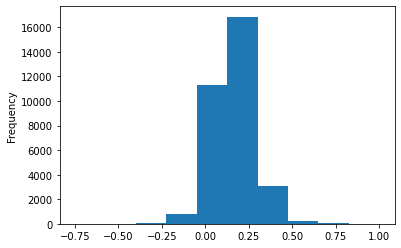

In [ ]:
sub_rev.polarity.plot.hist()

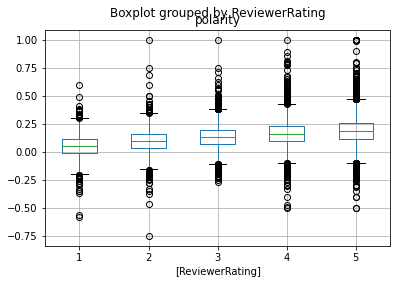

In [ ]:
sub_rev.boxplot(by=['ReviewerRating'],column=['polarity'])

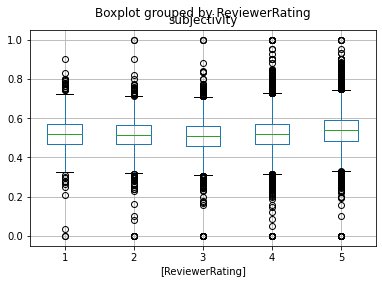

In [ ]:
sub_rev.boxplot(by=['ReviewerRating'],column=['subjectivity'])

In [ ]:
sub_rev.ReviewerRating.unique()

array(['4', '5', '3', '2', '1'], dtype=object)

In [ ]:
#label data
# 1,2 => 0(neg),4,5=>1(pos)
sub_rev['rating'] = np.where(sub_rev.ReviewerRating.isin(['1','2']),0,1)


In [ ]:
sub_rev = sub_rev.loc[sub_rev.ReviewerRating!='3',:]
sub_rev.shape

(27616, 5)

In [ ]:
sub_rev.rating.value_counts()

1    24111
0     3505
Name: rating, dtype: int64

In [ ]:
data = sub_rev.loc[:,['comment_nourl','rating']].reset_index(drop=True)
data.head()

,comment_nourl,rating
0,"My first book by Kristin Harmel was charming, ...",1
1,After reading some of Kristin Harmel's previou...,1
2,I really don't know where to begin and I am no...,1
3,I am an official reviewer for NetGalley. With ...,1
4,This book - This book. It hit me hard in all s...,1


In [ ]:
data.to_csv('processed_reviews.csv',index=False)

# Bert

## Setup

In [3]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [4]:
!pip install transformers

     |████████████████████████████████| 1.3MB 12.0MB/s 
     |████████████████████████████████| 1.1MB 48.8MB/s 
     |████████████████████████████████| 890kB 51.2MB/s 
     |████████████████████████████████| 2.9MB 49.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=019cc69820382fef4271d46a8d581dc06c535d26dbddcc452066481d5f2384f3
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [5]:
data = pd.read_csv('processed_reviews.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27616 entries, 0 to 27615
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   comment_nourl  27616 non-null  object
 1   rating         27616 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 431.6+ KB


In [ ]:
data.rating.value_counts()

1    24111
0     3505
Name: rating, dtype: int64

In [6]:
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


In [7]:
print('Loading BERT tokenizer...')
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME,do_lower_case=True)

Loading BERT tokenizer...


In [8]:
#Understand text length
token_lens = []
for txt in data.comment_nourl:
  tokens = tokenizer.encode(txt, max_length=512,truncation=True)
  token_lens.append(len(tokens))

KeyboardInterrupt: ignored

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Token count')

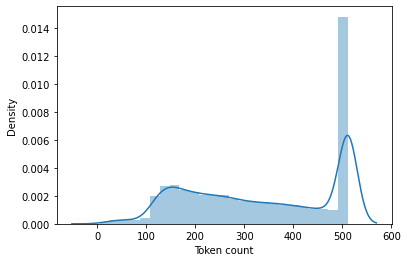

In [ ]:
sns.distplot(token_lens)

plt.xlabel('Token count')

In [ ]:
np.mean(np.array(token_lens)==512)
#30% length >=512

0.28143105446118194

In [ ]:
for i in range(5):
  print(data.comment_nourl[i])

My first book by Kristin Harmel was charming, complex, well-researched, and nostalgic. Emily Emerson receives a painting from Germany, and in doing so, uncovers an enormous secret about her family. There were times when I had to suspend disbelief a little regarding the romance between Emily's grandparents, and I definitely could; but overall, it made the book "feel" more like a dramatic romance with a great historical backdrop, rather than meatier historical fiction. Written in two timelines, the present day, and around WWII (involving the POW internment camps in Florida), When We Meet Again was a compelling read about families, forgiveness, and finding peace with the past.
After reading some of Kristin Harmel's previous novels and loving them, I knew I had to get my hands on this one too. Kristin has proven herself once again to be a skilled storyteller. When We Meet Again reminded me of The Sweetness of Forgetting, but there are some differences, as well. Both are about women who are

In [ ]:
#Based on literature review, keep head and tail words to make length 400

In [9]:
MAX_LEN = 512

In [10]:
#create pytorch data generator

class GPReviewDataset(Dataset):
  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  def __len__(self):
    return len(self.reviews)
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
      truncation=True
    )
    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [11]:
RANDOM_SEED = 32

In [12]:
df_train, df_test = train_test_split(
  data,
  test_size=0.05,
  random_state=RANDOM_SEED
)



In [13]:
df_test.rating.value_counts()

1    1198
0     183
Name: rating, dtype: int64

In [14]:
#downsample training data neg:pos = 1:2
N = np.sum(df_train.rating==0)*2
N

6644

In [15]:
#Downsample training data  to neg: pos = 1:2
shuffled_df = df_train.sample(frac=1,random_state=RANDOM_SEED)
neg_df = shuffled_df.loc[shuffled_df['rating'] == 0]
pos_df = shuffled_df.loc[shuffled_df['rating'] == 1].sample(n=N,random_state=RANDOM_SEED)
normalized_df = pd.concat([neg_df, pos_df])
normalized_df = normalized_df.sample(frac=1,random_state=RANDOM_SEED)


In [ ]:
normalized_df.rating.value_counts()

1    6682
0    3341
Name: rating, dtype: int64

In [16]:
df_train, df_dev = train_test_split(
  normalized_df,
  test_size=0.2,
  random_state=RANDOM_SEED
)

In [19]:
df_train.rating.value_counts()

1    5319
0    2653
Name: rating, dtype: int64

In [18]:
print(df_train.shape,df_dev.shape,df_test.shape)

(7972, 2) (1994, 2) (1381, 2)


In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.comment_nourl.to_numpy(),
    targets=df.rating.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
BATCH_SIZE = 8
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_dev, tokenizer, MAX_LEN, BATCH_SIZE)


## Model Training

In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
bert_model.config

BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "type_vocab_size": 2,
  "vocab_size": 30522
}

In [ ]:
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.5)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
model = SentimentClassifier(2) #only neg/pos classes
model = model.to(device)

Batch size: 16, 32

Learning rate (Adam): 5e-5, 3e-5, 2e-5

Number of epochs: 2, 3, 4 

In [ ]:
EPOCHS = 10
optimizer = AdamW(model.parameters(), lr=5e-6, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
from collections import defaultdict
import re

### Text lenghth > max_lenght
Next step : https://stackoverflow.com/questions/58636587/how-to-use-bert-for-long-text-classification

In [ ]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_dev)
  )
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  
  #json.dump( history, open( "history400.json", 'w' ) )

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state_512_lr5e-6.bin')
    best_accuracy = val_acc

  pd.DataFrame(history).to_csv("history512_lr5e-6.csv")



Epoch 1/10
----------
Train loss 0.31320505683032895 accuracy 0.8884846964375313
Val   loss 0.20526384644769133 accuracy 0.9358074222668004

Epoch 2/10
----------
Train loss 0.16966179768247072 accuracy 0.9581033617661816
Val   loss 0.26855700830346907 accuracy 0.9383149448345035

Epoch 3/10
----------
Train loss 0.10443813208549693 accuracy 0.9770446562970395
Val   loss 0.2956658550230786 accuracy 0.9373119358074222

Epoch 4/10
----------
Train loss 0.06933338420025732 accuracy 0.985574510787757
Val   loss 0.3573697216338478 accuracy 0.9358074222668004

Epoch 5/10
----------
Train loss 0.04482721203253063 accuracy 0.990592072252885
Val   loss 0.39550568625296 accuracy 0.9358074222668004

Epoch 6/10
----------
Train loss 0.029107936017534957 accuracy 0.994355243351731
Val   loss 0.42318812449497634 accuracy 0.9338014042126379

Epoch 7/10
----------
Train loss 0.022123679805344645 accuracy 0.9957350727546411
Val   loss 0.4314207650295866 accuracy 0.9353059177532598

Epoch 8/10
---------

In [ ]:
model = SentimentClassifier(2)
model.load_state_dict(torch.load('best_model_state_400.bin'))
model = model.to(device)

In [ ]:
history = pd.read_csv("history400.csv")

In [ ]:
def extract_value(x):
  temp = x.str.split(",").str[0]
  #print(temp)
  temp = temp.apply(lambda x: re.findall('\d+\.\d+',x)[0])
  #print(temp)
  temp = pd.to_numeric(temp)
  return temp

In [ ]:
history['train_acc'] = extract_value(history['train_acc'])
history['val_acc'] = extract_value(history['val_acc'])

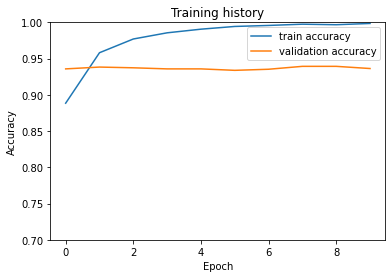

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.7, 1]);

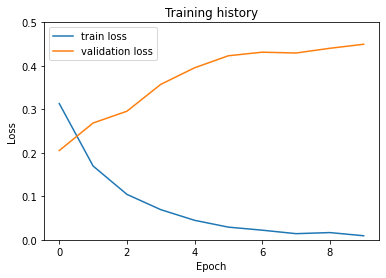

In [ ]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')
plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 0.5]);

## Testing and Prediction

In [ ]:
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)


In [ ]:
test_acc.item()

0.951484431571325

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
res = pd.DataFrame({'text':y_review_texts,'prediction':y_pred,'prob':y_pred_probs,'actual':y_test})
res.head()

,text,prediction,prob,actual
0,AMAZING!It has been SO LONG since I have read ...,1,"(tensor(-4.5335), tensor(5.0776))",1
1,I have to admit that when I started this book ...,1,"(tensor(-4.1604), tensor(4.5998))",1
2,I must admit that I didn't read the first book...,1,"(tensor(-4.5483), tensor(5.0489))",1
3,“I think back to that sunlit dayWhen I was you...,1,"(tensor(-4.5545), tensor(5.1523))",1
4,I’d love to chat all day about the seasons but...,1,"(tensor(-4.5550), tensor(5.1075))",1


In [ ]:
res.to_csv('result/bert_512_lr5e-6_pred.csv',index=False)

In [ ]:
print(classification_report(y_test, y_pred, target_names=['neg','pos']))

              precision    recall  f1-score   support

         neg       0.77      0.91      0.83       183
         pos       0.99      0.96      0.97      1198

    accuracy                           0.95      1381
   macro avg       0.88      0.93      0.90      1381
weighted avg       0.96      0.95      0.95      1381



In [ ]:
#using best model to predict
best_model = SentimentClassifier(2)
best_model.load_state_dict(torch.load('best_model_state_400_10.bin'))
best_model = best_model.to(device)

In [ ]:
test_acc_best, _ = eval_model(
  best_model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)
test_acc_best

tensor(0.9341, device='cuda:0', dtype=torch.float64)

In [ ]:
y_review_texts_best, y_pred_best, y_pred_probs_best, y_test_best = get_predictions(
  best_model,
  test_data_loader
)

In [ ]:
print(classification_report(y_test_best, y_pred_best, target_names=['neg','pos']))

              precision    recall  f1-score   support

         neg       0.66      0.90      0.76       164
         pos       0.99      0.94      0.96      1217

    accuracy                           0.93      1381
   macro avg       0.82      0.92      0.86      1381
weighted avg       0.95      0.93      0.94      1381



In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)

[[ 166   17]
 [  50 1148]]


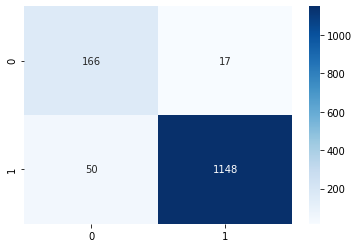

In [ ]:
import seaborn as sns
sns.heatmap(cf_matrix,annot=True,cmap='Blues', fmt='g')
#https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea